##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with Naive Bayes


**Student ID(s):**     1462539


## 0. Set-up

First, we import all the necessary libraries and load the labeled training data from `sms_supervised_train.csv`.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from typing import List, Set, Dict, Tuple

labelled_train = pd.read_csv('data/sms_supervised_train.csv')

Now that we have loaded our training dataset, let us delete rows where `textPreprocessed` is empty by calling `data.dropna`. These instances do not have any meaningful features we can learn from. After cleaning, we can then tokenise (split) the already preprossessd text for our next stage.

In [41]:
labelled_train.dropna(subset=['textPreprocessed'], inplace=True)
labelled_train['tokens'] = labelled_train['textPreprocessed'].apply(lambda x: x.split())

Let us define the **vocabulary**, which is a set of every word which occurs in the training data set

In [42]:
vocabulary = set()
for tokens in labelled_train['tokens']:
    vocabulary.update(tokens)
vocab_list = list(vocabulary)

Define **count** matrix (Bag-of-Words feature matrix). Since the dataset is already preprocessed, I am directly supplying `vocabulary` to `CountVectorizer` without calling `fit()`, to avoid any unintended token filtering. Note that we are going to follow the convention where $X$ represents the input features and $y$ represents the target labels; this notation is used consistently throughout the notebook.

In [43]:
vectorizer: CountVectorizer = CountVectorizer(vocabulary=vocab_list)
X: np.ndarray = vectorizer.transform(labelled_train['textPreprocessed'])
y: np.ndarray = labelled_train['class'].values

## 1. Supervised model training


### 1.1 Prior Probabilities

We are now ready to compute the prior probability of each class, $P(C)$. The result is returned as a dictionary mapping each class label to its corresponding prior probability: ${C : P(C)}$.

In [44]:
def calc_prior(data: pd.DataFrame, label_col: str = 'class') -> Dict[int, float]:
    class_counts = data[label_col].value_counts()
    total = class_counts.sum()
    return (class_counts / total).to_dict()

priors = calc_prior(labelled_train)

print(priors)

{0: 0.7994987468671679, 1: 0.20050125313283207}


### 1.2 Most Probable Words

The next set of probabilities we need to calculate are the conditional probabilities, which represent the likelihood of each feature value given a specific class label. Recall that our "count" matrix encodes how many times each word appears in a message. For example:

```
message1: [1, 0, 2] → "call now now"
message2: [0, 1, 1] → "win now"
```

To compute the **total word counts per class**, we sum the corresponding vectors:

```
[1 + 0, 0 + 1, 2 + 1] = [1, 1, 3]
```

Each entry in this resulting vector, `word_counts[i]`, corresponds to exactly $\text{count}_{c,i}$. where

$$
P(w_i \mid c) = \frac{\text{count}_{c,i} + \alpha}{\text{total}_c + V \alpha}.
$$

In [45]:
def calc_likelihood(X: np.ndarray, y: np.ndarray, alpha: float = 1.0) -> Dict[int, np.ndarray]:
    classes = np.unique(y)
    vocab_size = X.shape[1]
    likelihoods = {}

    for c in classes:
        X_c = X[y == c]                                 # rows for class c (y == c) is a mask
        word_counts = X_c.sum(axis=0)                   # sum over rows → word frequency vector
        word_counts = np.asarray(word_counts).flatten() # convert to 1D array
        total_count = word_counts.sum()
        likelihoods[c] = (word_counts + alpha) / (total_count + alpha * vocab_size)

    return likelihoods

likelihoods = calc_likelihood(X, y)

Let us now identify the most probable words in each class. Class $0$ represents non-malicious messages, while Class $1$ corresponds to scam messages.

In [46]:
def get_top_words(likelihood, vocab, class_label, top_n=10):
    indices = np.argsort(-likelihood[class_label])[:top_n] # - for descending order
    return [(vocab[i], likelihood[class_label][i]) for i in indices]

top_words_0 = get_top_words(likelihoods, vocab_list, 0)
top_words_1 = get_top_words(likelihoods, vocab_list, 1)

print("Top 10 most probable words in non-malicious class:")
for word, prob in top_words_0:
    print(f"{word}: {prob:.4f}")

print("\nTop 10 most probable words in scam class:")
for word, prob in top_words_1:
    print(f"{word}: {prob:.4f}")

Top 10 most probable words in non-malicious class:
go: 0.0161
get: 0.0143
gt: 0.0085
lt: 0.0084
call: 0.0083
ok: 0.0078
ur: 0.0075
come: 0.0075
know: 0.0075
love: 0.0071

Top 10 most probable words in scam class:
call: 0.0274
free: 0.0137
claim: 0.0100
customer: 0.0092
txt: 0.0090
ur: 0.0085
text: 0.0082
stop: 0.0082
reply: 0.0080
mobile: 0.0078


### 1.3 Most Predictive Words

Let us now get words that are most strongly predictive of each class. We can do this by computing the likelihood ratio,

$$
\text{Predictiveness} = \frac{P(w \mid \text{scam})}{P(w \mid \text{non-malicious})}.
$$

The ratio tells us **which words appear much more often in one class than the other**.

In [47]:
def get_predictive_words(likelihoods, vocab, top_n=10):
    ratio_1_over_0 = likelihoods[1] / likelihoods[0]
    ratio_0_over_1 = likelihoods[0] / likelihoods[1]
    top_1_indices = np.argsort(-ratio_1_over_0)[:top_n]
    top_0_indices = np.argsort(-ratio_0_over_1)[:top_n]
    top_scams = [(vocab[i], ratio_1_over_0[i]) for i in top_1_indices]
    top_nonmal = [(vocab[i], ratio_0_over_1[i]) for i in top_0_indices]
    return top_scams, top_nonmal

top_predictive_1, top_predictive_0 = get_predictive_words(likelihoods, vocab_list)

print("Top 10 most predictive words for scam class (P(w|1) / P(w|0)):")
for word, ratio in top_predictive_1:
    print(f"{word}: {ratio:.2f}")

print("\nTop 10 most predictive words for non-malicious class (P(w|0) / P(w|1)):")
for word, ratio in top_predictive_0:
    print(f"{word}: {ratio:.2f}")

Top 10 most predictive words for scam class (P(w|1) / P(w|0)):
prize: 88.80
tone: 57.46
select: 41.79
claim: 41.21
50: 34.82
paytm: 33.08
code: 31.34
award: 28.73
won: 27.86
18: 26.12

Top 10 most predictive words for non-malicious class (P(w|0) / P(w|1)):
gt: 60.30
lt: 59.73
lor: 32.16
ok: 27.57
hope: 27.57
da: 22.40
let: 20.10
wat: 19.53
oh: 18.38
lol: 17.80


### 1.x Posterior Probabilities

Given a message represented as a "count" vector $\mathbf{x} = (x_1, x_2, \dots, x_V)$, where $x_i$ is the number of times word $i$ appears and $V$ is the vocabulary size, the posterior probability of class $c$ is proportional to,


$$
P(c \mid \mathbf{x}) \propto P(c) \cdot \prod_{i=1}^{V} P(w_i \mid c)^{x_i},
$$

as given in the specification. However, to avoid running into underflow problems when multiplying very small probabilities, we are going to take log on both sides:

$$
\log P(c \mid \mathbf{x}) \propto \log P(c) + \sum_{i=1}^{V} x_i \cdot \log P(w_i \mid c).
$$

In [48]:
def calc_posterior(counts: np.ndarray, priors: Dict[int, float], likelihoods: Dict[int, np.ndarray]) -> Dict[int, float]:
    scores = {}
    for c in priors:
        log_prior = np.log(priors[c])
        log_likelihood = np.log(likelihoods[c])
        scores[c] = log_prior + np.dot(counts, log_likelihood)
    return scores

# test_text = "call for free burger!"
# test_counts = vectorizer.transform([test_text]).toarray()[0]
# scores = calc_posterior(test_counts, priors, likelihoods)

# prediction = max(scores, key=scores.get)
# print(f"Prediction for: '{test_text}' →", "scam" if prediction == 1 else "non-malicious")

## 2. Supervised model evaluation

### 2.a Predicting Test Set

Let us now move onto predicting label for our given test set. To assess the confidence of our prediction, we calculate the ratio of the posterior probabilities for each class. This ratio tells us how much more likely the message is to belong to the "scam" class compared to the "non-malicious" class.

$$
\text{Confidence} = \frac{P(\text{scam} \mid \textbf{x})}{P(\text{non-malicious} \mid \textbf{x})}
$$

In [49]:
def predict_batch(texts: List[str], priors: Dict[int, float], likelihoods: Dict[int, np.ndarray], 
                  vectorizer: CountVectorizer) -> Tuple[np.ndarray, np.ndarray]:
    predictions: List[int] = []
    confidence_ratios: List[float] = []

    for text in texts:
        # Transform the text into a count vector
        counts: np.ndarray = vectorizer.transform([text]).toarray().flatten()
        # Calculate posterior scores for each class
        scores: Dict[int, float] = calc_posterior(counts, priors, likelihoods)
        # Append the predicted class (class with the highest posterior score)
        predictions.append(max(scores, key=scores.get))
        # Append the confidence ratio (P(class 1) / P(class 0))
        confidence_ratios.append(np.exp(scores[1] - scores[0]))

    return np.array(predictions), np.array(confidence_ratios)

In [50]:
test_df = pd.read_csv('data/sms_test.csv')
test_df.dropna(subset=['textPreprocessed'], inplace=True)

test_texts = test_df['textPreprocessed'].tolist()
true_labels = test_df['class'].values
predicted_labels, confidence_ratios = predict_batch(test_texts, priors, likelihoods, vectorizer)

### 2.1 Model Performance Evaluation

I will use the `sklearn` library to evaluate the performance of my Naive Bayes model.

In [51]:
def eval_model(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Error Rate": 1 - accuracy_score(y_true, y_pred),
    }

def print_eval(eval: Dict[str, float]) -> None:
    for metric, value in eval.items():
        print(f"{metric}: {value:.4f}")

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str = "") -> None:
    plt.figure(figsize=(5, 4.5))
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # Flip: scam (1) comes first
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Scam', 'Non-malicious'], 
                yticklabels=['Scam', 'Non-malicious'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if title:
        plt.title(title)
    plt.tight_layout()
    #plt.savefig("base.svg", format="svg")
    plt.show()

Accuracy: 0.9700
Precision: 0.9381
Recall: 0.9100
F1 Score: 0.9239
Error Rate: 0.0300


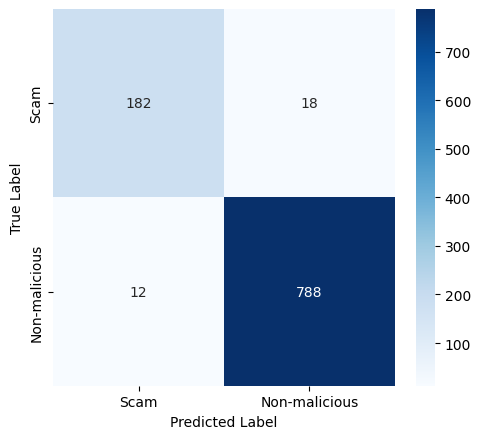

In [52]:
eval_results = eval_model(true_labels, predicted_labels)
print_eval(eval_results)
plot_confusion_matrix(true_labels, predicted_labels)

### 2.2 Out-of-Vocabulary (OOV) Words

Note that I have already removed test instances that are already empty, and those are not counted in skipped messages.

In [53]:
oov_words = 0
total_words = 0
skipped_messages = 0

for text in test_texts:
    tokens = text.split()
    total_words += len(tokens)
    tokens_in_vocab = [token for token in tokens if token in vocabulary]
    if not tokens_in_vocab:
        skipped_messages += 1
    oov_words += len(tokens) - len(tokens_in_vocab)

print(f"OOV Words: {oov_words}")
print(f"Total Words: {total_words}")
print(f"Percentage of OOV Words: {(oov_words / total_words)*100:.4f}%")
print(f"Skipped Messages (no tokens in vocab): {skipped_messages}")

OOV Words: 179
Total Words: 10968
Percentage of OOV Words: 1.6320%
Skipped Messages (no tokens in vocab): 0


### 2.3 Examples of High and Low Confidence

In [54]:
test_df['prediction'] = predicted_labels
test_df['confidence_ratio'] = confidence_ratios
test_df['distance_to_boundary'] = abs(test_df['confidence_ratio'] - 1)

print("\n--- High Confidence Scam Predictions ---")
high_conf_scam = test_df[test_df['prediction'] == 1].sort_values(by='confidence_ratio', ascending=False).head(3)
print(high_conf_scam[['textOriginal', 'textPreprocessed', 'confidence_ratio']])

print("\n--- High Confidence Non-Malicious Predictions ---")
high_conf_nonmal = test_df[test_df['prediction'] == 0].sort_values(by='confidence_ratio', ascending=True).head(3)
print(high_conf_nonmal[['textOriginal', 'textPreprocessed', 'confidence_ratio']])

print("\n--- Boundary Cases (Confidence Ratio ≈ 1) ---")
boundary = test_df.sort_values(by='distance_to_boundary', ascending=True).head(3)
print(boundary[['textOriginal', 'textPreprocessed', 'confidence_ratio']])


--- High Confidence Scam Predictions ---
                                          textOriginal  \
555  Todays Vodafone numbers ending 5347 are select...   
349  Todays Vodafone numbers ending 3156 are select...   
44   Todays Voda numbers ending 5226 are selected t...   

                                      textPreprocessed  confidence_ratio  
555  . please call award apply end rs. vodafone tod...      1.866963e+17  
349  . please call award apply end rs. vodafone tod...      1.400222e+17  
44   ? . please call award end 350 todays voda numb...      1.069614e+17  

--- High Confidence Non-Malicious Predictions ---
                                          textOriginal  \
341  NEFT Transaction with reference number  &lt;#&...   
16   no, i *didn't* mean to post it. I wrote it, an...   
659  U wake up already? Wat u doing? U picking us u...   

                                      textPreprocessed  confidence_ratio  
341  time : rs. transaction number & & & & & & & & ...      1.1827

## 3. Extending the model with semi-supervised training (Option 2: Active Learning)

We will use our current supervised model to generate predictions on the unlabelled messages. The `predict_batch` function returns class predictions and confidence scores.

In [55]:
unlabelled_train = pd.read_csv('data/sms_unlabelled.csv')
unlabelled_train.dropna(subset=['textPreprocessed'], inplace=True)

_, conf_unlabelled = predict_batch(unlabelled_train['textPreprocessed'].tolist(), priors, likelihoods, vectorizer)
unlabelled_train['confidence_ratio'] = conf_unlabelled
unlabelled_train['distance_to_boundary'] = np.abs(unlabelled_train['confidence_ratio'] - 1)
unlabelled_train['tokens'] = unlabelled_train['textPreprocessed'].apply(lambda x: x.split())


Split the supervised train into **train** and **validation** set using stratified sampling.

In [56]:
train, validation = train_test_split(labelled_train, test_size=0.1, stratify=labelled_train['class'], random_state=373)
print(f"Train set size: {len(train)}")
print(f"Validation set size: {len(validation)}")

Train set size: 1795
Validation set size: 200


### Select 200 Unlabelled Instances using Three Strategies

In [57]:
# Strategy 1: random 200
random_200 = unlabelled_train.sample(n=200, random_state=109).drop(columns=['confidence_ratio', 'distance_to_boundary'])
expanded_random = pd.concat([train, random_200], ignore_index=True)

# Strategy 2: low-confidence 200
lowconf_200 = unlabelled_train.nsmallest(200, 'distance_to_boundary').drop(columns=['confidence_ratio', 'distance_to_boundary'])
expanded_lowconf = pd.concat([train, lowconf_200], ignore_index=True)

# Strategy 3: high-confidence 200
highconf_200 = unlabelled_train.nlargest(200, 'distance_to_boundary').drop(columns=['confidence_ratio', 'distance_to_boundary'])
expanded_highconf = pd.concat([train, highconf_200], ignore_index=True)

In [58]:
def train_and_predict(train_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[Dict[int, np.ndarray], np.ndarray, np.ndarray]:
    vocab = set()
    for tokens in train_df['tokens']:
        vocab.update(tokens)
    vocab_list = list(vocab)
    
    vectorizer = CountVectorizer(vocabulary=vocab_list)
    X = vectorizer.transform(train_df['textPreprocessed'])
    y = train_df['class'].values

    priors = calc_prior(train_df)
    likelihoods = calc_likelihood(X, y)

    pred, conf = predict_batch(test_df['textPreprocessed'].tolist(), priors, likelihoods, vectorizer)
    return vocab_list, likelihoods, pred, conf


In [59]:
_, _, pred_random, conf_random = train_and_predict(expanded_random, validation)
_, _, pred_lowconf, conf_lowconf = train_and_predict(expanded_lowconf, validation)
_, _, pred_highconf, conf_highconf = train_and_predict(expanded_highconf, validation)

### Testing with Validation Set

--- Evaluation Metrics for Random 200 ---
Accuracy: 0.9650
Precision: 0.8837
Recall: 0.9500
F1 Score: 0.9157
Error Rate: 0.0350

--- Evaluation Metrics for Low-Confidence 200 ---
Accuracy: 0.9750
Precision: 0.9070
Recall: 0.9750
F1 Score: 0.9398
Error Rate: 0.0250

--- Evaluation Metrics for High-Confidence 200 ---
Accuracy: 0.9550
Precision: 0.8605
Recall: 0.9250
F1 Score: 0.8916
Error Rate: 0.0450

--- Confusion Matrix for Random 200 ---


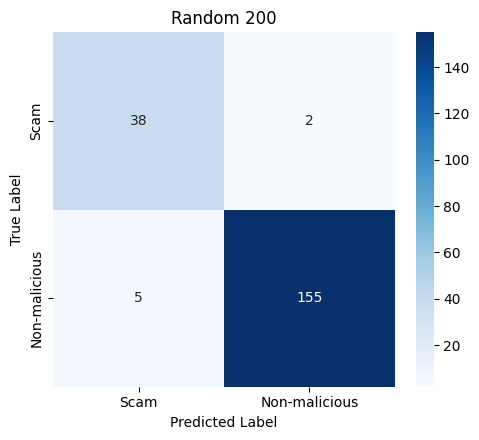


--- Confusion Matrix for Low-Confidence 200 ---


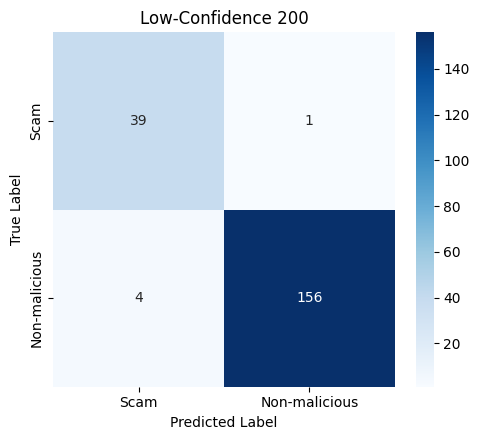


--- Confusion Matrix for High-Confidence 200 ---


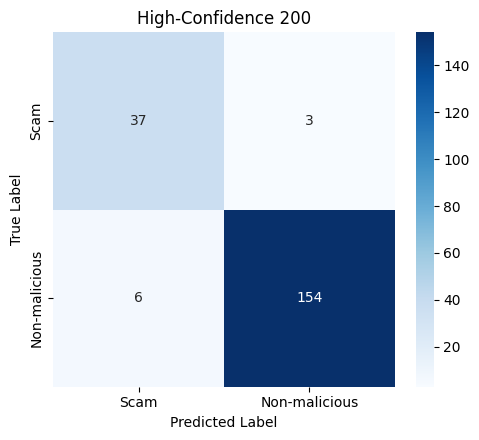

In [60]:
metrics_random = eval_model(validation['class'].values, pred_random)
metrics_lowconf = eval_model(validation['class'].values, pred_lowconf)
metrics_highconf = eval_model(validation['class'].values, pred_highconf)

print("--- Evaluation Metrics for Random 200 ---")
print_eval(metrics_random)
print("\n--- Evaluation Metrics for Low-Confidence 200 ---")
print_eval(metrics_lowconf)
print("\n--- Evaluation Metrics for High-Confidence 200 ---")
print_eval(metrics_highconf)
print("\n--- Confusion Matrix for Random 200 ---")
plot_confusion_matrix(validation['class'].values, pred_random, title = "Random 200")
print("\n--- Confusion Matrix for Low-Confidence 200 ---")
plot_confusion_matrix(validation['class'].values, pred_lowconf, title = "Low-Confidence 200")
print("\n--- Confusion Matrix for High-Confidence 200 ---")
plot_confusion_matrix(validation['class'].values, pred_highconf, title = "High-Confidence 200")

## 4. Supervised model evaluation

--- Evaluation Metrics for Low-Confidence 200 on Test Set ---
Accuracy: 0.9750
Precision: 0.9534
Recall: 0.9200
F1 Score: 0.9364
Error Rate: 0.0250

--- Confusion Matrix for Low-Confidence 200 on Test Set ---


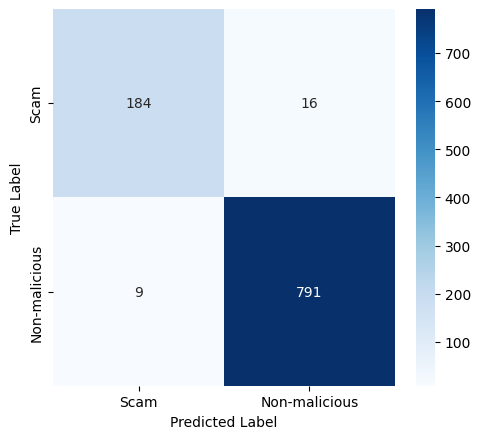

In [61]:
vocab_expand, like_expand, pred, conf = train_and_predict(expanded_lowconf, test_df)
metrics = eval_model(test_df['class'].values, pred)

print("--- Evaluation Metrics for Low-Confidence 200 on Test Set ---")
print_eval(metrics)
print("\n--- Confusion Matrix for Low-Confidence 200 on Test Set ---")
plot_confusion_matrix(test_df['class'].values, pred)

In [62]:
predictive_lowconf0, predictive_lowconf1 = get_predictive_words(like_expand, vocab_expand)

print("\nTop 10 most predictive words for non-malicious class (P(w|0) / P(w|1)) - Low-Confidence 200:")
for word, ratio in predictive_lowconf1:
    print(f"{word}: {ratio:.2f}")

print("\nTop 10 most predictive words for scam class (P(w|1) / P(w|0)) - Low-Confidence 200:")
for word, ratio in predictive_lowconf0:
    print(f"{word}: {ratio:.2f}")


Top 10 most predictive words for non-malicious class (P(w|0) / P(w|1)) - Low-Confidence 200:
gt: 56.00
lt: 56.00
ok: 51.91
lor: 29.75
da: 19.83
wat: 17.50
let: 17.50
lol: 16.33
something: 16.33
sorry: 16.04

Top 10 most predictive words for scam class (P(w|1) / P(w|0)) - Low-Confidence 200:
prize: 77.15
tone: 54.86
claim: 54.00
select: 34.29
paytm: 32.57
cs: 30.86
18: 25.72
code: 25.72
won: 24.00
award: 22.29
